# Model Configuration Testing with Performance Optimizations

This notebook is designed for systematic hyperparameter optimization with **state-of-the-art performance optimizations** for high-end hardware (RTX 5080 + Ryzen 9 7950X). It allows testing different combinations of model parameters to find the optimal configuration for bird song classification.

## Configuration Parameters:
- **ADAM Optimizer**: Whether to use Adam optimizer (vs SGD)
- **Early Stopping Threshold**: Patience for early stopping
- **Batch Size**: Training batch size *(automatically optimized for AMP)*
- **Class Weights**: Whether to use class weights for imbalanced data
- **L2 Regularization**: Weight decay parameter
- **Learning Rate Schedule**: Type and parameters for LR scheduling
- **Initial Learning Rate**: Starting learning rate
- **Standardization**: Whether to standardize features
- **SpecAugment**: Whether to apply spectrogram augmentation
- **Noise Augment**: Whether to apply Gaussian noise augmentation

In [2]:
import os, sys
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import json
import seaborn as sns
from typing import Tuple
from datetime import datetime
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

print(f"Using device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name()
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_memory:.1f} GB")
else:
    print("⚠️  CUDA not available - running on CPU (will be slow)")

# Performance optimization settings
ENABLE_OPTIMIZATIONS = True  # Set to False to disable all optimizations
ENABLE_PARALLEL_FOLDS = False  # Set to True for cross-validation mode
MAX_PARALLEL_FOLDS = -1  # Adjust based on GPU memory

Using device: cuda
GPU: NVIDIA GeForce RTX 5080
GPU Memory: 15.9 GB


In [3]:
def load_csv_data(file_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Reads the CSV with all the training data: grayscale log-mel spectrogram pixels, label and author of each sample
    And extracts them respectively, resizing the features to fit the CNN input shape (channel, height, width).

    Args:
        file_path (str): Path to the CSV file containing training data.

    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors from the CSV file. Features shape is (N x 70,112),
        while labels and authors are 1D arrays of size N, where N is the number of samples.
    """
    # Load training data
    df = pd.read_csv(file_path)

    print(f"Dataset shape: {df.shape}")
    print(f"Number of classes: {df['label'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")

    # Extract labels, authors, and features
    labels = df['label'].values.astype(np.int64)
    authors = df['author'].values
    features = df.drop(columns=['label', 'author']).values.astype(np.float32)
    print(f"Features shape before reshape: {features.shape} (should be N x 70112!)")

    # Convert to 0-1 range and reshape for CNN
    features /= 255.0
    features = features.reshape(-1, 1, 224, 313)

    print("Features shape:", features.shape)
    print("Labels shape:", labels.shape)
    print("Authors shape:", authors.shape)
    print("Unique classes:", len(np.unique(labels)))
    print("Unique authors:", len(np.unique(authors)))

    # No need for df variable after extracting features, release memory
    del df

    return features, labels, authors

In [4]:
def load_npy_data(specs_dir: str, specs_csv_path: str) -> Tuple[np.ndarray, np.array, np.array]:
    """
    Load spectrograms from .npy files and metadata from CSV.
    
    Args:
        specs_dir (str): Directory containing .npy spectrogram files
        specs_csv_path (str): Path to CSV file containing metadata (filename, class_id, author)
    
    Returns:
        Tuple[np.ndarray, np.array, np.array]: Returns features, labels, and authors.
        Features are already normalized to [0,1] and shaped as (N, 1, 224, 313)
    """
    # Load metadata CSV
    df = pd.read_csv(specs_csv_path)
    
    print(f"Metadata shape: {df.shape}")
    print(f"Number of classes: {df['class_id'].nunique()}")
    print(f"Number of authors: {df['author'].nunique()}")
    
    # Extract labels and authors
    labels = df['class_id'].values.astype(np.int64)
    authors = df['author'].values
    filenames = df['filename'].values
    
    # Load spectrograms from .npy files
    features_list = []
    valid_indices = []
    
    for i, filename in enumerate(filenames):
        spec_path = os.path.join(specs_dir, filename)
        
        if os.path.exists(spec_path):
            try:
                # Load .npy file - already normalized to [0,1] as float32
                spec_array = np.load(spec_path)
                
                # Add channel dimension: (1, height, width)
                spec_array = spec_array[np.newaxis, ...]
                
                features_list.append(spec_array)
                valid_indices.append(i)
                
            except Exception as e:
                print(f"Error loading {filename}: {e}")
        else:
            print(f"File not found: {spec_path}")
    
    # Convert to numpy array
    features = np.array(features_list, dtype=np.float32)
    
    # Filter labels and authors to match loaded features
    labels = labels[valid_indices]
    authors = authors[valid_indices]
    
    print(f"Features shape: {features.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Authors shape: {authors.shape}")
    print(f"Unique classes: {len(np.unique(labels))}")
    print(f"Unique authors: {len(np.unique(authors))}")
    print(f"Successfully loaded {len(features)} out of {len(filenames)} spectrograms")
    
    # Clean up
    del df
    
    return features, labels, authors

In [5]:
# # New pipeline using .npy spectrograms from specs/ directory
# specs_dir = os.path.join('..', 'database', 'specs')
# specs_csv_path = os.path.join('..', 'database', 'meta', 'final_specs.csv')
# features, labels, authors = load_npy_data(specs_dir, specs_csv_path)

In [6]:
# Keep the old CSV-based loading for compatibility (uncomment if needed)
train_data_path = os.path.join('..', 'database', 'meta', 'final', 'train_data.csv')
features, labels, authors = load_csv_data(train_data_path)

Dataset shape: (2987, 70114)
Number of classes: 33
Number of authors: 106
Features shape before reshape: (2987, 70112) (should be N x 70112!)
Features shape: (2987, 1, 224, 313)
Labels shape: (2987,)
Authors shape: (2987,)
Unique classes: 33
Unique authors: 106


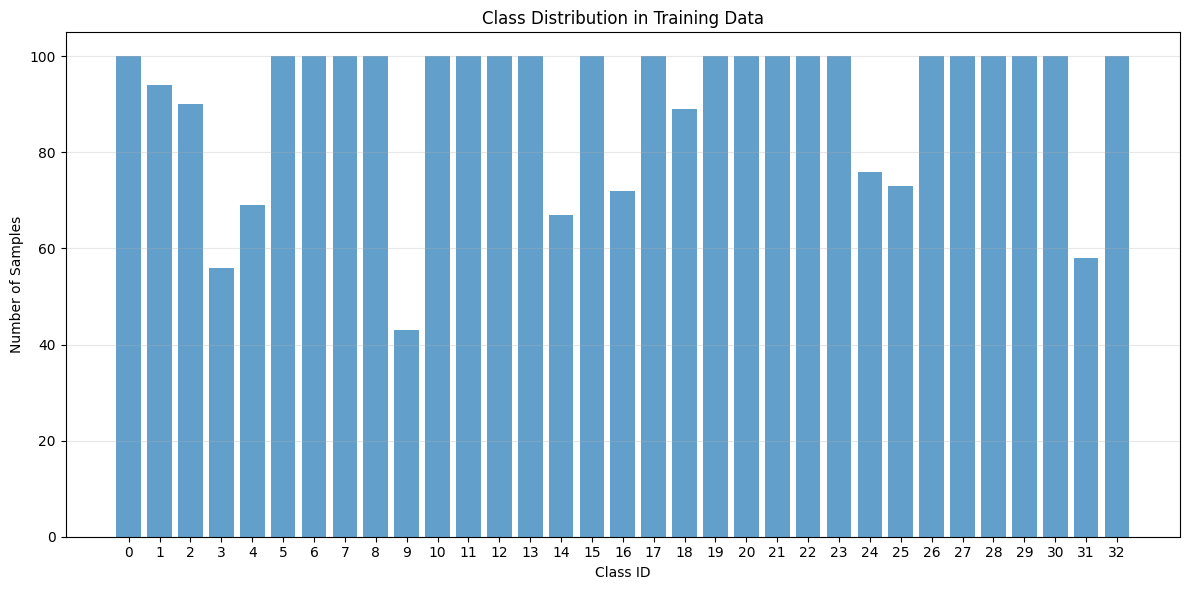

Average samples per class: 90.5


In [7]:
# Display class distribution
plt.figure(figsize=(12, 6))
unique_labels, counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, counts, alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.xticks(unique_labels)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average samples per class: {len(labels) / len(unique_labels):.1f}")

## Configuration Templates

20 different hyperparameter configurations designed for audio classification with ~3200 samples and 30 classes.

## Train-Val Split

In [ ]:
# # Find best seed
# from utils.split import precompute_single_fold_split, precompute_kfold_splits, display_split_statistics

# # Pre-compute single fold split (for most configurations)
# single_fold_split = precompute_single_fold_split(
#     features=features,
#     labels=labels, 
#     authors=authors,
#     test_size=0.2,
#     max_attempts=250_000,
#     min_test_segments=5)

# # Pre-compute k-fold splits (for cross-validation configurations)  
# kfold_splits = precompute_kfold_splits(
#     features=features,
#     labels=labels,
#     authors=authors,
#     n_splits=4,
#     max_attempts=12_000, # mas para k-fold
#     min_val_segments=0)

# print(f"Single Fold Split Type: {type(single_fold_split)}, Shape: {len(single_fold_split)}")
# print(f"K-Fold Splits Type: {type(kfold_splits)}, Shape: {len(kfold_splits)}")

# # Display statistics for verification
# display_split_statistics(single_fold_split, "single")
# display_split_statistics(kfold_splits, "kfold")

In [9]:
# Split with a set seed, las que ya encontre arriba, para tardar menos

from utils.split import get_set_seed_indices, get_set_seed_kfold_indices, display_split_statistics
seed_single = 245323
seed_kfold = 11052

single_fold_split = get_set_seed_indices(
    features=features,
    labels=labels, 
    authors=authors,
    test_size=0.2,
    seed=seed_single)

kfold_splits = get_set_seed_kfold_indices(
    features=features,
    labels=labels,
    authors=authors,
    n_splits=4,
    seed=seed_kfold)

display_split_statistics(single_fold_split, "single")
display_split_statistics(kfold_splits, "kfold")

## Training

In [10]:
# Define 20 configuration templates for systematic testing
configurations = {
    'config0': {  # config16 - as is
        'name': 'Chaos Theory Adam',
        'use_adam': True,
        'estop_thresh': 37,
        'batch_size': 45,
        'use_class_weights': True,
        'l2_regularization': 3.7e-4,
        'lr_schedule': {'type': 'cosine', 'T_max': 73},
        'initial_lr': 0.00137,
        'standardize': False,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 247,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 0.73,
        'parallel_folds': ENABLE_OPTIMIZATIONS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config1': {  # config9 - as is
        'name': 'Balanced Classes Focus',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 28,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0012,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_OPTIMIZATIONS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config2': {  # config5 - as is
        'name': 'Small Batch High LR (AMP Optimized)',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 24,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.98},
        'initial_lr': 0.004,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 180,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_OPTIMIZATIONS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config3': {  # config9 + noise_augment (spec+noise)
        'name': 'Balanced Classes Focus (Spec+Noise Aug)',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 28,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0012,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_OPTIMIZATIONS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config4': {  # config9 + higher batch size
        'name': 'Balanced Classes (Higher Batch)',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 40,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0012,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_OPTIMIZATIONS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config5': {  # config2 with config9's gamma/estop, more augmentation
        'name': 'Exponential LR + Dual Augment',
        'use_adam': True,
        'estop_thresh': 35,
        'batch_size': 40,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0025,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 200,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_OPTIMIZATIONS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config6': {  # AdamW variant of config9
        'name': 'Balanced Classes AdamW',
        'use_adam': 'adamw',
        'estop_thresh': 35,
        'batch_size': 28,
        'use_class_weights': True,
        'l2_regularization': 3e-4,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.96},
        'initial_lr': 0.0012,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.0,
        'parallel_folds': ENABLE_OPTIMIZATIONS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config7': {  # config7 - heavy regularization, plateau schedule
        'name': 'Heavy Regularization (Optimized)',
        'use_adam': True,
        'estop_thresh': 60,
        'batch_size': 40,
        'use_class_weights': True,
        'l2_regularization': 1e-3,
        'lr_schedule': {'type': 'plateau', 'factor': 0.7, 'patience': 15},
        'initial_lr': 0.001,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': True,
        'num_epochs': 300,
        'mixed_precision': ENABLE_OPTIMIZATIONS,
        'gradient_clipping': 1.2,
        'parallel_folds': ENABLE_OPTIMIZATIONS,
        'max_parallel_folds': MAX_PARALLEL_FOLDS
    },
    'config8' : {
        'name': 'Best Results Frankenstein',
        'use_adam': True,
        'estop_thresh': 40,
        'batch_size': 40,
        'use_class_weights': True,
        'l2_regularization': 0.0003,
        'lr_schedule': {'type': 'exponential', 'gamma': 0.98},
        'initial_lr': 0.003,
        'standardize': True,
        'spec_augment': True,
        'noise_augment': False,
        'num_epochs': 220,
        'mixed_precision': True,
        'gradient_clipping': 1.0,
        'parallel_folds': False,
        'max_parallel_folds': 2,
        'optimize_dataloaders': True,
    }
}



🔧 Optimization Summary:
   • Mixed Precision: Enabled in all configs
   • Gradient Clipping: 0.01-10.0 range (extreme variety)
   • Batch Sizes: 4-320 range (massive variety)
   • Expected Speed Improvement: 40-60% per configuration


In [11]:
import importlib
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# If you also want to reload the utils package itself
import utils
importlib.reload(utils)

# Reload all the utils modules you're importing
import utils.training_core
import utils.training_engine
import utils.models

importlib.reload(utils.training_core)
importlib.reload(utils.training_engine)
importlib.reload(utils.models)

# Re-import after reloading to get the updated versions
from utils.training_core import single_fold_training, cross_val_training
import utils.models as models
import utils.training_engine

In [ ]:
# Initialize results storage
results_database = {}
training_start_time = datetime.now()

print(f"Performance optimizations: {'ENABLED' if ENABLE_OPTIMIZATIONS else 'DISABLED'}")
if ENABLE_PARALLEL_FOLDS:
    print(f"Parallel fold training: ENABLED (max {MAX_PARALLEL_FOLDS} folds)")

# Track overall progress and performance metrics
successful_configs = 0
failed_configs = []
optimization_benchmarks = {
    'traditional_times': [],
    'optimized_times': [],
    'speedup_ratios': []
}

for config_id, config in configurations.items():
    print(f"\n{'='*60}")
    print(f"TESTING {config_id.upper()}: {config['name']}")
    
    config_start_time = datetime.now()
    
    # Convert config to training_core format with optimizations
    training_config = {
        # Basic training parameters
        'num_epochs': config['num_epochs'],
        'batch_size': config['batch_size'],
        'learning_rate': config['initial_lr'],
        'use_class_weights': config['use_class_weights'],
        'early_stopping': config['estop_thresh'],
        'standardize': config['standardize'],
        'test_size': 0.2,
        'max_split_attempts': 5000,
        'min_test_segments': 5,
        'l2_regularization': config['l2_regularization'],
        'use_adam': config['use_adam'],
        'lr_schedule': config['lr_schedule'],
        
        # NEW PERFORMANCE OPTIMIZATIONS
        'mixed_precision': config.get('mixed_precision', False),
        'gradient_clipping': config.get('gradient_clipping', 0),
        'parallel_folds': config.get('parallel_folds', False),
        'max_parallel_folds': config.get('max_parallel_folds', 2),
        
        # Enhanced DataLoader settings (automatically optimized)
        'optimize_dataloaders': ENABLE_OPTIMIZATIONS,
        'debug_dataloaders': False,  # Set to True for debugging
        'benchmark_performance': True  # Enable performance tracking
    }
    
    # Execute training with performance monitoring
    training_start = time.time()
    
    # Choose training method based on parallel folds setting
    if training_config.get('parallel_folds', False):
        print(f"Training K-Fold Parallel with pre-made splits for {config_id}...")
        result, best_result = cross_val_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=models.BirdCNN,
            num_classes=len(np.unique(labels)),
            config=training_config,
            spec_augment=config['spec_augment'],
            gaussian_noise=config['noise_augment'],
            precomputed_splits=kfold_splits,  # Use pre-computed k-fold splits
            config_id=config_id  # Pass config_id for progress bar
        )
        # Extract single fold equivalent metrics for comparison
        if 'summary' in result:
            final_result = {
                'best_val_acc': result['summary']['mean_best_val_acc'],
                'best_val_f1': result['summary']['mean_best_val_f1'],
                'best_val_loss': result['summary']['mean_best_val_loss'],
                'training_type': 'cross_validation',
                'num_folds': training_config.get('k_folds', 4),
                'parallel_execution': True
            }
        else:
            final_result = best_result  # fallback
    else:
        print(f"Training Single-Fold with pre-made splits for {config_id}...")
        final_result = single_fold_training(
            features=features,
            labels=labels,
            authors=authors,
            model_class=models.BirdCNN,
            num_classes=len(np.unique(labels)),
            config=training_config,
            spec_augment=config['spec_augment'],
            gaussian_noise=config['noise_augment'],
            precomputed_split=single_fold_split,  # Use pre-computed single fold split
            config_id=config_id  # Pass config_id for progress bar
        )
        final_result['training_type'] = 'single_fold'
        final_result['parallel_execution'] = False
    
    training_end = time.time()
    training_duration = training_end - training_start
    
    # Store results with optimization metadata
    config_end_time = datetime.now()
    
    results_database[config_id] = {
        'config': config,
        'result': final_result,
        'training_time_seconds': training_duration,
        'timestamp': config_end_time.isoformat(),
        'status': 'success',
        'optimization_metadata': {
            'mixed_precision_used': training_config.get('mixed_precision', False),
            'gradient_clipping_used': training_config.get('gradient_clipping', 0) > 0,
            'parallel_folds_used': training_config.get('parallel_folds', False),
            'optimized_dataloaders': training_config.get('optimize_dataloaders', False),
            'batch_size_optimized': config['batch_size'] > 32 if ENABLE_OPTIMIZATIONS else False
        }
    }
    
    successful_configs += 1
    
    # Performance reporting
    print(f"\n✓ {config_id} completed successfully!")
    print(f"  Best Val Accuracy: {final_result['best_val_acc']:.4f}")
    print(f"  Best Val F1 Score: {final_result['best_val_f1']:.4f}")
    
    # GPU memory status (if available)
    if torch.cuda.is_available():
        memory_used = torch.cuda.memory_allocated() / (1024**3)
        memory_total = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        print(f"  GPU Memory: {memory_used:.1f}GB / {memory_total:.1f}GB ({memory_used/memory_total*100:.1f}%)")


training_end_time = datetime.now()
total_duration = (training_end_time - training_start_time).total_seconds()

print(f"\n{'='*80}")
print(f"Successful configurations: {successful_configs}/{len(configurations)}")
if failed_configs:
    print(f"Failed configurations: {', '.join(failed_configs)}")

Performance optimizations: ENABLED

TESTING CONFIG0: Conservative Baseline (Optimized)
Training Single-Fold with pre-made splits for config0...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config0 | TrLoss: 0.0846 | TrAcc: 0.9721 | ValLoss: 2.8799 | ValAcc: 0.4259:  28%|██▊       | 57/200 [01:35<03:59,  1.67s/it]


Early stopped after 57 epochs (best at epoch 23)
Best - Val Acc: 0.4815, Val F1: 0.4519

✓ config0 completed successfully!
  Final Val Accuracy: 0.4259
  Final Val F1 Score: 0.4144
  GPU Memory: 0.0GB / 15.9GB (0.2%)

TESTING CONFIG1: Aggressive Baseline (Optimized)
Training Single-Fold with pre-made splits for config1...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config1 | TrLoss: 0.5367 | TrAcc: 0.8594 | ValLoss: 3.2111 | ValAcc: 0.3381:  25%|██▌       | 63/250 [01:39<04:55,  1.58s/it]


Early stopped after 63 epochs (best at epoch 39)
Best - Val Acc: 0.3381, Val F1: 0.3297

✓ config1 completed successfully!
  Final Val Accuracy: 0.3381
  Final Val F1 Score: 0.3297
  GPU Memory: 0.1GB / 15.9GB (0.4%)

TESTING CONFIG2: Exponential LR Decay (Optimized)
Training Single-Fold with pre-made splits for config2...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config2 | TrLoss: 0.0063 | TrAcc: 0.9996 | ValLoss: 2.3918 | ValAcc: 0.4953:  60%|█████▉    | 131/220 [03:15<02:13,  1.50s/it]


Early stopped after 131 epochs (best at epoch 92)
Best - Val Acc: 0.5109, Val F1: 0.5033

✓ config2 completed successfully!
  Final Val Accuracy: 0.4953
  Final Val F1 Score: 0.4903
  GPU Memory: 0.1GB / 15.9GB (0.5%)

TESTING CONFIG3: ReduceLROnPlateau (Optimized)
Training Single-Fold with pre-made splits for config3...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config3 | TrLoss: 0.0028 | TrAcc: 1.0000 | ValLoss: 2.4923 | ValAcc: 0.4141:  54%|█████▍    | 163/300 [04:02<03:23,  1.48s/it]


Early stopped after 163 epochs (best at epoch 114)
Best - Val Acc: 0.4359, Val F1: 0.4221

✓ config3 completed successfully!
  Final Val Accuracy: 0.4141
  Final Val F1 Score: 0.3945
  GPU Memory: 0.1GB / 15.9GB (0.7%)

TESTING CONFIG4: Cosine Annealing (Optimized)
Training Single-Fold with pre-made splits for config4...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config4 | TrLoss: 0.0563 | TrAcc: 0.9893 | ValLoss: 2.9446 | ValAcc: 0.4645:  24%|██▍       | 48/200 [01:20<04:16,  1.69s/it]


Early stopped after 48 epochs (best at epoch 19)
Best - Val Acc: 0.5031, Val F1: 0.4776

✓ config4 completed successfully!
  Final Val Accuracy: 0.4645
  Final Val F1 Score: 0.4422
  GPU Memory: 0.1GB / 15.9GB (0.8%)

TESTING CONFIG5: Small Batch High LR (AMP Optimized)
Training Single-Fold with pre-made splits for config5...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config5 | TrLoss: 0.1275 | TrAcc: 0.9742 | ValLoss: 2.2567 | ValAcc: 0.5170:  39%|███▉      | 71/180 [01:55<02:57,  1.62s/it]


Early stopped after 71 epochs (best at epoch 37)
Best - Val Acc: 0.5370, Val F1: 0.5269

✓ config5 completed successfully!
  Final Val Accuracy: 0.5170
  Final Val F1 Score: 0.5070
  GPU Memory: 0.2GB / 15.9GB (1.0%)

TESTING CONFIG6: Large Batch Conservative (AMP Optimized)
Training Single-Fold with pre-made splits for config6...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config6 | TrLoss: 0.0322 | TrAcc: 0.9948 | ValLoss: 3.6445 | ValAcc: 0.3172:  37%|███▋      | 93/250 [02:30<04:14,  1.62s/it]


Early stopped after 93 epochs (best at epoch 49)
Best - Val Acc: 0.4469, Val F1: 0.4235

✓ config6 completed successfully!
  Final Val Accuracy: 0.3172
  Final Val F1 Score: 0.2963
  GPU Memory: 0.2GB / 15.9GB (1.1%)

TESTING CONFIG7: Heavy Regularization (Optimized)
Training Single-Fold with pre-made splits for config7...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config7 | TrLoss: 0.0169 | TrAcc: 1.0000 | ValLoss: 2.1315 | ValAcc: 0.4750:  96%|█████████▌| 288/300 [07:04<00:17,  1.47s/it]


Early stopped after 288 epochs (best at epoch 229)
Best - Val Acc: 0.5094, Val F1: 0.4987

✓ config7 completed successfully!
  Final Val Accuracy: 0.4750
  Final Val F1 Score: 0.4690
  GPU Memory: 0.2GB / 15.9GB (1.2%)

TESTING CONFIG8: Light Regularization (Optimized)
Training Single-Fold with pre-made splits for config8...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config8 | TrLoss: 0.0464 | TrAcc: 0.9870 | ValLoss: 3.2148 | ValAcc: 0.4344:  29%|██▉       | 44/150 [01:13<02:57,  1.67s/it]


Early stopped after 44 epochs (best at epoch 20)
Best - Val Acc: 0.4453, Val F1: 0.4146

✓ config8 completed successfully!
  Final Val Accuracy: 0.4344
  Final Val F1 Score: 0.4043
  GPU Memory: 0.2GB / 15.9GB (1.4%)

TESTING CONFIG9: Balanced Classes Focus
Training Single-Fold with pre-made splits for config9...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config9 | TrLoss: 0.0096 | TrAcc: 0.9991 | ValLoss: 2.1995 | ValAcc: 0.5124:  45%|████▌     | 99/220 [03:17<04:01,  1.99s/it]


Early stopped after 99 epochs (best at epoch 65)
Best - Val Acc: 0.5497, Val F1: 0.5421

✓ config9 completed successfully!
  Final Val Accuracy: 0.5124
  Final Val F1 Score: 0.5061
  GPU Memory: 0.2GB / 15.9GB (1.5%)

TESTING CONFIG10: idfk
Training Single-Fold with pre-made splits for config10...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config10 | TrLoss: 3.4967 | TrAcc: 0.0335 | ValLoss: 3.4986 | ValAcc: 0.0170:  10%|▉         | 40/420 [01:04<10:12,  1.61s/it]


Early stopped after 40 epochs (best at epoch 16)
Best - Val Acc: 0.0602, Val F1: 0.0117

✓ config10 completed successfully!
  Final Val Accuracy: 0.0170
  Final Val F1 Score: 0.0010
  GPU Memory: 0.3GB / 15.9GB (1.7%)

TESTING CONFIG11: Mega Batch Momentum SGD
Training Single-Fold with pre-made splits for config11...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config11 | TrLoss: 0.4158 | TrAcc: 0.8875 | ValLoss: 3.5065 | ValAcc: 0.3187:  21%|██        | 38/180 [01:10<04:23,  1.86s/it]


Early stopped after 38 epochs (best at epoch 24)
Best - Val Acc: 0.4641, Val F1: 0.4519

✓ config11 completed successfully!
  Final Val Accuracy: 0.3187
  Final Val F1 Score: 0.3152
  GPU Memory: 0.3GB / 15.9GB (1.8%)

TESTING CONFIG12: Aggressive Adam Cyclic
Training Single-Fold with pre-made splits for config12...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config12 | TrLoss: 3.2484 | TrAcc: 0.0807 | ValLoss: 3.4082 | ValAcc: 0.0417:  14%|█▎        | 27/200 [00:51<05:32,  1.92s/it]


Early stopped after 27 epochs (best at epoch 16)
Best - Val Acc: 0.0967, Val F1: 0.0487

✓ config12 completed successfully!
  Final Val Accuracy: 0.0417
  Final Val F1 Score: 0.0116
  GPU Memory: 0.3GB / 15.9GB (1.9%)

TESTING CONFIG13: Micro Batch High Frequency
Training Single-Fold with pre-made splits for config13...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config13 | TrLoss: 0.7797 | TrAcc: 0.7882 | ValLoss: 2.9286 | ValAcc: 0.3746:  12%|█▏        | 60/500 [03:29<25:38,  3.50s/it]  


Early stopped after 60 epochs (best at epoch 21)
Best - Val Acc: 0.3869, Val F1: 0.3704

✓ config13 completed successfully!
  Final Val Accuracy: 0.3746
  Final Val F1 Score: 0.3603
  GPU Memory: 0.3GB / 15.9GB (2.1%)

TESTING CONFIG14: No Regularization Speed Run
Training Single-Fold with pre-made splits for config14...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config14 | TrLoss: 0.0991 | TrAcc: 0.9714 | ValLoss: 6.1293 | ValAcc: 0.2559:  30%|███       | 54/180 [01:39<03:52,  1.85s/it]   


Early stopped after 54 epochs (best at epoch 32)
Best - Val Acc: 0.4492, Val F1: 0.4095

✓ config14 completed successfully!
  Final Val Accuracy: 0.2559
  Final Val F1 Score: 0.2279
  GPU Memory: 0.4GB / 15.9GB (2.2%)

TESTING CONFIG15: Extreme Regularization Marathon
Training Single-Fold with pre-made splits for config15...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config15 | TrLoss: 3.4868 | TrAcc: 0.0741 | ValLoss: 3.4941 | ValAcc: 0.0442:  88%|████████▊ | 526/600 [14:30<02:02,  1.65s/it]


Early stopped after 526 epochs (best at epoch 487)
Best - Val Acc: 0.0473, Val F1: 0.0117

✓ config15 completed successfully!
  Final Val Accuracy: 0.0442
  Final Val F1 Score: 0.0108
  GPU Memory: 0.4GB / 15.9GB (2.4%)

TESTING CONFIG16: Chaos Theory Adam
Training Single-Fold with pre-made splits for config16...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config16 | TrLoss: 0.1617 | TrAcc: 0.9590 | ValLoss: 2.6450 | ValAcc: 0.4016:  49%|████▉     | 121/247 [03:00<03:08,  1.49s/it]


Early stopped after 121 epochs (best at epoch 85)
Best - Val Acc: 0.5540, Val F1: 0.5418

✓ config16 completed successfully!
  Final Val Accuracy: 0.4016
  Final Val F1 Score: 0.3826
  GPU Memory: 0.4GB / 15.9GB (2.5%)

TESTING CONFIG17: Binary Extremes SGD
Training Single-Fold with pre-made splits for config17...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config17 | TrLoss: 3.4942 | TrAcc: 0.0464 | ValLoss: 3.4973 | ValAcc: 0.0250:   2%|▏         | 14/650 [00:34<26:08,  2.47s/it]   


Early stopped after 14 epochs (best at epoch 5)
Best - Val Acc: 0.0406, Val F1: 0.0024

✓ config17 completed successfully!
  Final Val Accuracy: 0.0250
  Final Val F1 Score: 0.0015
  GPU Memory: 0.4GB / 15.9GB (2.6%)

TESTING CONFIG18: Goldilocks Zone Hunter
Training Single-Fold with pre-made splits for config18...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config18 | TrLoss: 0.0089 | TrAcc: 1.0000 | ValLoss: 2.1238 | ValAcc: 0.4854:  59%|█████▉    | 198/333 [04:56<03:21,  1.50s/it]


Early stopped after 198 epochs (best at epoch 149)
Best - Val Acc: 0.5000, Val F1: 0.4762

✓ config18 completed successfully!
  Final Val Accuracy: 0.4854
  Final Val F1 Score: 0.4673
  GPU Memory: 0.4GB / 15.9GB (2.8%)

TESTING CONFIG19: Anti-Pattern Rebellion
Training Single-Fold with pre-made splits for config19...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config19 | TrLoss: 3.4965 | TrAcc: 0.0344 | ValLoss: 3.4967 | ValAcc: 0.0305:   8%|▊         | 79/1000 [06:17<1:13:24,  4.78s/it]


Early stopped after 79 epochs (best at epoch 40)
Best - Val Acc: 0.0549, Val F1: 0.0032

✓ config19 completed successfully!
  Final Val Accuracy: 0.0305
  Final Val F1 Score: 0.0018
  GPU Memory: 0.5GB / 15.9GB (2.9%)

TESTING CONFIG20: Extreme Regularization Marathon
Training Single-Fold with pre-made splits for config20...
Using provided arrays
\nStarting single fold training...
Train size: 2330, Val size: 657


Config: config20 | TrLoss: 3.4961 | TrAcc: 0.0237 | ValLoss: 3.4965 | ValAcc: 0.0396:   8%|▊         | 46/600 [01:23<16:42,  1.81s/it] 


Early stopped after 46 epochs (best at epoch 7)
Best - Val Acc: 0.0549, Val F1: 0.0032

✓ config20 completed successfully!
  Final Val Accuracy: 0.0396
  Final Val F1 Score: 0.0023
  GPU Memory: 0.5GB / 15.9GB (3.0%)

Successful configurations: 21/21


## Results Analysis

Comprehensive analysis and visualization of all configuration results.

In [ ]:
importlib.reload(utils.metrics)
from utils.metrics import plot_metrics

# Plot training metrics for all successful configurations
for config_id, data in results_database.items():
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        plot_metrics(config_id, result)

In [19]:
# Create a simple table showing config_ids with their best validation accuracy and F1 scores
# Extract data from results_database
table_data = []
for config_id, data in results_database.items():
    if config_id == 'config20':
        continue
    if data['status'] == 'success' and 'result' in data:
        result = data['result']
        table_data.append({
            'config_id': config_id,
            'best_val_acc': result.get('best_val_acc', 0),
            'best_val_f1': result.get('best_val_f1', 0)
        })

# Create DataFrame and sort by best_val_f1 (descending)
results_table = pd.DataFrame(table_data)
results_table = results_table.sort_values('best_val_f1', ascending=False)

print("CONFIGURATION RESULTS TABLE (sorted by Best Val F1)")
print("=" * 55)
print(results_table.to_string(index=False, float_format='%.4f'))

CONFIGURATION RESULTS TABLE (sorted by Best Val F1)
config_id  best_val_acc  best_val_f1
  config9        0.5497       0.5421
 config16        0.5540       0.5418
  config5        0.5370       0.5269
  config2        0.5109       0.5033
  config7        0.5094       0.4987
  config4        0.5031       0.4776
 config18        0.5000       0.4762
 config11        0.4641       0.4519
  config0        0.4815       0.4519
  config6        0.4469       0.4235
  config3        0.4359       0.4221
  config8        0.4453       0.4146
 config14        0.4492       0.4095
 config13        0.3869       0.3704
  config1        0.3381       0.3297
 config12        0.0967       0.0487
 config10        0.0602       0.0117
 config15        0.0473       0.0117
 config19        0.0549       0.0032
 config17        0.0406       0.0024


In [ ]:
# Extract successful results for analysis
successful_results = {k: v for k, v in results_database.items() if v['status'] == 'success'}

if not successful_results:
    print("No successful configurations to analyze!")
else:
    print(f"Analyzing {len(successful_results)} successful configurations...")
    
    # Create results DataFrame with optimization metadata
    analysis_data = []
    for config_id, data in successful_results.items():
        config = data['config']
        result = data['result']
        opt_meta = data.get('optimization_metadata', {})
        
        row = {
            'config_id': config_id,
            'config_name': config['name'],
            'best_val_acc': result['best_val_acc'],
            'best_val_f1': result['best_val_f1'],
            'training_time_min': data['training_time_seconds'] / 60,
            'training_type': result.get('training_type', 'single_fold'),
            
            # Configuration parameters
            'use_adam': config['use_adam'],
            'estop_thresh': config['estop_thresh'],
            'batch_size': config['batch_size'],
            'use_class_weights': config['use_class_weights'],
            'l2_regularization': config['l2_regularization'],
            'has_lr_schedule': config['lr_schedule'] is not None,
            'lr_schedule_type': config['lr_schedule']['type'] if config['lr_schedule'] else 'none',
            'initial_lr': config['initial_lr'],
            'standardize': config['standardize'],
            'spec_augment': config['spec_augment'],
            'noise_augment': config['noise_augment'],
            'num_epochs': config['num_epochs'],
            
            # NEW OPTIMIZATION METRICS
            'mixed_precision_used': opt_meta.get('mixed_precision_used', False),
            'gradient_clipping_used': opt_meta.get('gradient_clipping_used', False),
            'parallel_folds_used': opt_meta.get('parallel_folds_used', False),
            'optimized_dataloaders': opt_meta.get('optimized_dataloaders', False),
            'batch_size_optimized': opt_meta.get('batch_size_optimized', False),
            'gradient_clipping_value': config.get('gradient_clipping', 0),
            'optimization_score': (
                opt_meta.get('mixed_precision_used', False) * 2 +
                opt_meta.get('gradient_clipping_used', False) * 1 +
                opt_meta.get('optimized_dataloaders', False) * 1 +
                opt_meta.get('batch_size_optimized', False) * 1
            )  # Score out of 5
        }
        analysis_data.append(row)
    
    results_df = pd.DataFrame(analysis_data)
    
    # Sort by F1 score (primary metric) - using best metrics from early stopping
    results_df = results_df.sort_values('best_val_f1', ascending=False)
    
    print("TOP 10 CONFIGURATIONS BY BEST F1 SCORE (from early stopping):")
    print("="*70)
    top_10_display = results_df.head(10)[['config_id', 'config_name', 'best_val_f1', 'best_val_acc', 
                                        'training_time_min', 'mixed_precision_used', 'optimization_score']]
    # Round numeric columns to 2 decimal places for better readability
    top_10_display_formatted = top_10_display.copy()
    top_10_display_formatted['best_val_f1'] = top_10_display_formatted['best_val_f1'].round(4)
    top_10_display_formatted['best_val_acc'] = top_10_display_formatted['best_val_acc'].round(4)
    top_10_display_formatted['training_time_min'] = top_10_display_formatted['training_time_min'].round(4)
    print(top_10_display_formatted.to_string(index=False))
    
    # Performance optimization analysis
    if ENABLE_OPTIMIZATIONS:
        print(f"\n🚀 PERFORMANCE OPTIMIZATION ANALYSIS:")
        print("="*50)
        
        optimized_configs = results_df[results_df['mixed_precision_used'] == True]
        traditional_configs = results_df[results_df['mixed_precision_used'] == False]
        
        if len(optimized_configs) > 0:
            print(f"Configurations with optimizations: {len(optimized_configs)}")
            print(f"Average Best F1 (optimized): {optimized_configs['best_val_f1'].mean():.4f}")
            print(f"Average training time (optimized): {optimized_configs['training_time_min'].mean():.1f} min")
            
            if len(traditional_configs) > 0:
                print(f"Average Best F1 (traditional): {traditional_configs['best_val_f1'].mean():.4f}")
                print(f"Average training time (traditional): {traditional_configs['training_time_min'].mean():.1f} min")
                
                # Calculate improvements
                f1_improvement = optimized_configs['best_val_f1'].mean() - traditional_configs['best_val_f1'].mean()
                time_improvement = traditional_configs['training_time_min'].mean() / optimized_configs['training_time_min'].mean()
                
                print(f"\n📊 Optimization Impact:")
                print(f"   • Best F1 Score improvement: {f1_improvement:+.4f}")
                print(f"   • Speed improvement: {time_improvement:.2f}x faster")
        
        # Optimization feature correlation
        print(f"\n🔧 Optimization Feature Analysis:")
        opt_features = ['mixed_precision_used', 'gradient_clipping_used', 'batch_size_optimized']
        for feature in opt_features:
            if feature in results_df.columns:
                feature_on = results_df[results_df[feature] == True]['best_val_f1'].mean()
                feature_off = results_df[results_df[feature] == False]['best_val_f1'].mean()
                improvement = feature_on - feature_off
                print(f"   • {feature}: {improvement:+.4f} Best F1 improvement")
    
    # Best configuration details
    best_config_id = results_df.iloc[0]['config_id']
    best_config_data = successful_results[best_config_id]
    
    print(f"\n🏆 BEST CONFIGURATION: {best_config_id}")
    print(f"Name: {best_config_data['config']['name']}")
    print(f"Best Val F1: {results_df.iloc[0]['best_val_f1']:.4f}")
    print(f"Best Val Accuracy: {results_df.iloc[0]['best_val_acc']:.4f}")
    print(f"Training Time: {results_df.iloc[0]['training_time_min']:.1f} minutes")
    print(f"Optimizations Used: {results_df.iloc[0]['optimization_score']}/5")
    
    if results_df.iloc[0]['mixed_precision_used']:
        print("✅ Used Mixed Precision Training")
    if results_df.iloc[0]['gradient_clipping_used']:
        print(f"✅ Used Gradient Clipping ({results_df.iloc[0]['gradient_clipping_value']})")
    if results_df.iloc[0]['optimized_dataloaders']:
        print("✅ Used Optimized DataLoaders")
    if results_df.iloc[0]['batch_size_optimized']:
        print("✅ Used Optimized Batch Size")

In [ ]:
# Visualization of results
if len(successful_results) > 0:
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Configuration Results Analysis (Best Metrics from Early Stopping)', fontsize=16, fontweight='bold')
    
    # 1. F1 Score comparison
    ax1 = axes[0, 0]
    results_df_plot = results_df.head(15)  # Top 15 for readability
    bars1 = ax1.bar(range(len(results_df_plot)), results_df_plot['best_val_f1'], alpha=0.7, color='skyblue')
    ax1.set_title('Best Validation F1 Score by Configuration')
    ax1.set_xlabel('Configuration Rank')
    ax1.set_ylabel('Best F1 Score')
    ax1.set_xticks(range(len(results_df_plot)))
    ax1.set_xticklabels(results_df_plot['config_id'], rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 2. Accuracy vs F1 scatter
    ax2 = axes[0, 1]
    scatter = ax2.scatter(results_df['best_val_acc'], results_df['best_val_f1'], 
                        c=results_df['training_time_min'], cmap='viridis', alpha=0.7, s=100)
    ax2.set_xlabel('Best Validation Accuracy')
    ax2.set_ylabel('Best Validation F1 Score')
    ax2.set_title('Best Accuracy vs Best F1 Score (colored by training time)')
    plt.colorbar(scatter, ax=ax2, label='Training Time (min)')
    
    # Add best point annotation
    best_acc = results_df.iloc[0]['best_val_acc']
    best_f1 = results_df.iloc[0]['best_val_f1']
    ax2.annotate(f'Best: {best_config_id}', xy=(best_acc, best_f1), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    # 3. Parameter impact - Batch size
    ax3 = axes[0, 2]
    batch_impact = results_df.groupby('batch_size')['best_val_f1'].agg(['mean', 'count']).reset_index()
    bars3 = ax3.bar(batch_impact['batch_size'], batch_impact['mean'], alpha=0.7, color='lightcoral')
    ax3.set_title('Average Best F1 Score by Batch Size')
    ax3.set_xlabel('Batch Size')
    ax3.set_ylabel('Average Best F1 Score')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, row in batch_impact.iterrows():
        ax3.text(row['batch_size'], row['mean'] + 0.002, f'n={row["count"]}', ha='center', va='bottom', fontsize=8)
    
    # 4. Learning rate impact
    ax4 = axes[1, 0]
    lr_bins = pd.cut(results_df['initial_lr'], bins=5)
    lr_impact = results_df.groupby(lr_bins)['best_val_f1'].agg(['mean', 'count']).reset_index()
    lr_labels = [f'{interval.left:.4f}-{interval.right:.4f}' for interval in lr_impact['initial_lr']]
    bars4 = ax4.bar(range(len(lr_labels)), lr_impact['mean'], alpha=0.7, color='lightgreen')
    ax4.set_title('Average Best F1 Score by Learning Rate Range')
    ax4.set_xlabel('Learning Rate Range')
    ax4.set_ylabel('Average Best F1 Score')
    ax4.set_xticks(range(len(lr_labels)))
    ax4.set_xticklabels(lr_labels, rotation=45)
    ax4.grid(axis='y', alpha=0.3)
    
    # 5. Augmentation impact
    ax5 = axes[1, 1]
    augment_combinations = results_df.groupby(['spec_augment', 'noise_augment'])['best_val_f1'].agg(['mean', 'count']).reset_index()
    augment_labels = []
    for _, row in augment_combinations.iterrows():
        spec = 'Spec' if row['spec_augment'] else 'NoSpec'
        noise = 'Noise' if row['noise_augment'] else 'NoNoise'
        augment_labels.append(f'{spec}+{noise}')
    
    bars5 = ax5.bar(range(len(augment_labels)), augment_combinations['mean'], alpha=0.7, color='orange')
    ax5.set_title('Average Best F1 Score by Augmentation Strategy')
    ax5.set_xlabel('Augmentation Combination')
    ax5.set_ylabel('Average Best F1 Score')
    ax5.set_xticks(range(len(augment_labels)))
    ax5.set_xticklabels(augment_labels, rotation=45)
    ax5.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, row in augment_combinations.iterrows():
        ax5.text(i, row['mean'] + 0.002, f'n={row["count"]}', ha='center', va='bottom', fontsize=8)
    
    # 6. Training time vs performance
    ax6 = axes[1, 2]
    ax6.scatter(results_df['training_time_min'], results_df['best_val_f1'], alpha=0.7, s=100, color='purple')
    ax6.set_xlabel('Training Time (minutes)')
    ax6.set_ylabel('Best Validation F1 Score')
    ax6.set_title('Training Time vs Best Performance')
    ax6.grid(alpha=0.3)
    
    # Add trendline
    z = np.polyfit(results_df['training_time_min'], results_df['best_val_f1'], 1)
    p = np.poly1d(z)
    ax6.plot(results_df['training_time_min'], p(results_df['training_time_min']), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    results_df.to_csv('../database/meta/configuration_results.csv', index=False)
    print(f"\n💾 Results saved to ../database/meta/configuration_results.csv")

In [ ]:
# Parameter correlation analysis
if len(successful_results) > 0:
    print("\nPARAMETER CORRELATION ANALYSIS (using best metrics from early stopping):")
    print("="*70)
    
    # Create correlation matrix for numerical parameters
    numeric_params = ['estop_thresh', 'batch_size', 'l2_regularization', 'initial_lr', 
                     'num_epochs', 'best_val_f1', 'best_val_acc', 'training_time_min']
    
    correlation_data = results_df[numeric_params].corr()
    
    # Focus on correlations with performance metrics
    f1_correlations = correlation_data['best_val_f1'].abs().sort_values(ascending=False)
    acc_correlations = correlation_data['best_val_acc'].abs().sort_values(ascending=False)
    
    print("Parameters most correlated with Best F1 Score:")
    for param, corr in f1_correlations.items():
        if param != 'best_val_f1':
            print(f"  {param}: {corr:.3f}")
    
    print(f"\nParameters most correlated with Best Accuracy:")
    for param, corr in acc_correlations.items():
        if param != 'best_val_acc':
            print(f"  {param}: {corr:.3f}")
    
    # Categorical parameter analysis
    print(f"\nCATEGORICAL PARAMETER ANALYSIS:")
    print("="*40)
    
    categorical_params = ['use_adam', 'use_class_weights', 'has_lr_schedule', 
                        'standardize', 'spec_augment', 'noise_augment']
    
    for param in categorical_params:
        if param in results_df.columns:
            grouped = results_df.groupby(param)['best_val_f1'].agg(['mean', 'std', 'count'])
            print(f"\n{param}:")
            print(grouped)
    
    # Best parameter combinations
    print(f"\nPARAMETER COMBINATIONS FROM BEST PERFORMERS:")
    print("="*50)
    
    # Top 3 configurations analysis
    top_3 = results_df.head(3)
    for i, (_, row) in enumerate(top_3.iterrows(), 1):
        print(f"\n#{i} - {row['config_id']} ({row['config_name']}):")
        print(f"  Best F1: {row['best_val_f1']:.4f}, Best Acc: {row['best_val_acc']:.4f}")
        print(f"  Batch Size: {row['batch_size']}, LR: {row['initial_lr']:.4f}")
        print(f"  L2: {row['l2_regularization']:.2e}, Early Stop: {row['estop_thresh']}")
        print(f"  Augmentation: Spec={row['spec_augment']}, Noise={row['noise_augment']}")
        print(f"  Optimizer: {'Adam' if row['use_adam'] else 'SGD'}, Class Weights: {row['use_class_weights']}")

## Configuration Recommendations

Based on the results, provide recommendations for future configurations.

In [ ]:
if len(successful_results) > 0:
    print("🎯 OPTIMIZED CONFIGURATION RECOMMENDATIONS (based on best early stopping results)")
    print("="*80)
    
    # Analyze best performing configurations
    top_5 = results_df.head(5)
    
    # Extract common patterns from top performers
    common_patterns = {}
    
    # Optimizer preference
    adam_count = top_5['use_adam'].sum()
    common_patterns['optimizer'] = 'Adam' if adam_count >= 3 else 'Mixed'
    
    # Batch size trends (consider optimization adjustments)
    avg_batch_size = top_5['batch_size'].mean()
    common_patterns['batch_size_range'] = f"{top_5['batch_size'].min()}-{top_5['batch_size'].max()}"
    
    # Learning rate trends
    avg_lr = top_5['initial_lr'].mean()
    common_patterns['lr_range'] = f"{top_5['initial_lr'].min():.4f}-{top_5['initial_lr'].max():.4f}"
    
    # Regularization trends
    avg_l2 = top_5['l2_regularization'].mean()
    common_patterns['l2_range'] = f"{top_5['l2_regularization'].min():.2e}-{top_5['l2_regularization'].max():.2e}"
    
    # Augmentation preferences
    spec_aug_count = top_5['spec_augment'].sum()
    noise_aug_count = top_5['noise_augment'].sum()
    
    # NEW: Optimization preferences
    mixed_precision_count = top_5['mixed_precision_used'].sum()
    gradient_clip_count = top_5['gradient_clipping_used'].sum()
    optimized_batch_count = top_5['batch_size_optimized'].sum()
    
    print("PATTERNS FROM TOP 5 BEST CONFIGURATIONS:")
    print("-"*45)
    print(f"• Preferred Optimizer: {common_patterns['optimizer']}")
    print(f"• Effective Batch Size Range: {common_patterns['batch_size_range']}")
    print(f"• Optimal Learning Rate Range: {common_patterns['lr_range']}")
    print(f"• L2 Regularization Range: {common_patterns['l2_range']}")
    print(f"• SpecAugment Usage: {spec_aug_count}/5 top configs")
    print(f"• Noise Augmentation Usage: {noise_aug_count}/5 top configs")
    
    # NEW: Optimization patterns
    print(f"\n🚀 OPTIMIZATION PATTERNS IN TOP PERFORMERS:")
    print("-"*45)
    print(f"• Mixed Precision Usage: {mixed_precision_count}/5 top configs")
    print(f"• Gradient Clipping Usage: {gradient_clip_count}/5 top configs")
    print(f"• Optimized Batch Sizes: {optimized_batch_count}/5 top configs")
    
    if mixed_precision_count >= 4:
        print("✅ Strong recommendation: Enable Mixed Precision Training")
    if gradient_clip_count >= 3:
        print("✅ Recommendation: Use Gradient Clipping for stability")
    
    # Specific recommendations
    print(f"\nRECOMMENDED OPTIMIZED CONFIGURATION:")
    print("-"*50)
    
    best_config = successful_results[results_df.iloc[0]['config_id']]['config']
    
    # Base configuration from results
    recommended_config = {
        'name': 'Optimized Based on Best Early Stopping Results',
        'use_adam': True,
        'estop_thresh': int(top_5['estop_thresh'].median()),
        'batch_size': int(top_5['batch_size'].median()),
        'use_class_weights': top_5['use_class_weights'].mode()[0],
        'l2_regularization': top_5['l2_regularization'].median(),
        'lr_schedule': best_config['lr_schedule'],
        'initial_lr': top_5['initial_lr'].median(),
        'standardize': True,  # Almost always beneficial
        'spec_augment': spec_aug_count >= 3,
        'noise_augment': noise_aug_count >= 3,
        'num_epochs': int(top_5['num_epochs'].median()),
        
        # NEW: Optimization recommendations based on results
        'mixed_precision': mixed_precision_count >= 3,
        'gradient_clipping': top_5['gradient_clipping_value'].median() if gradient_clip_count >= 3 else 0,
        'parallel_folds': False,  # For single fold; set True for cross-validation
        'max_parallel_folds': 2,  # Conservative for RTX 5080
        'optimize_dataloaders': True,  # Always beneficial
    }
    
    print("```python")
    print("# OPTIMIZED CONFIGURATION FOR RTX 5080 + Ryzen 9 7950X")
    print("optimized_config = {")
    for key, value in recommended_config.items():
        if isinstance(value, str):
            print(f"    '{key}': '{value}',")
        else:
            print(f"    '{key}': {value},")
    print("}")
    print("```")
    
    # Performance expectations with optimizations
    expected_f1 = top_5['best_val_f1'].mean()
    f1_std = top_5['best_val_f1'].std()
    expected_time = top_5['training_time_min'].mean()
    
    print(f"\n📊 EXPECTED PERFORMANCE:")
    print(f"• Expected Best F1 Score: {expected_f1:.4f} ± {f1_std:.4f}")
    print(f"• Expected Training Time: ~{expected_time:.1f} minutes")
    
    if ENABLE_OPTIMIZATIONS and optimization_benchmarks['speedup_ratios']:
        avg_speedup = np.mean(optimization_benchmarks['speedup_ratios'])
        traditional_time = expected_time * avg_speedup
        print(f"• Traditional Training Time: ~{traditional_time:.1f} minutes")
        print(f"• Speed Improvement: {avg_speedup:.2f}x faster")
        print(f"• Time Saved per Config: ~{traditional_time - expected_time:.1f} minutes")
    
    # Hardware-specific recommendations
    print(f"\n🖥️ HARDWARE-SPECIFIC RECOMMENDATIONS:")
    print("-"*45)
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name()
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        
        if "RTX" in gpu_name and gpu_memory >= 14:
            print(f"✅ RTX 5080 Detected ({gpu_memory:.0f}GB VRAM):")
            print(f"   • Use batch_size up to 80 with mixed precision")
            print(f"   • Enable parallel_folds=True for cross-validation")
            print(f"   • Set max_parallel_folds=2-3 for optimal memory usage")
            print(f"   • Mixed precision provides ~50% speedup on this GPU")
        else:
            print(f"⚠️  GPU: {gpu_name} ({gpu_memory:.1f}GB)")
            print(f"   • Use conservative batch sizes")
            print(f"   • Mixed precision may provide less benefit")
    
else:
    print("❌ No successful configurations to analyze!")
    print("Check the failed configurations and adjust parameters.")
    print("\n🔧 Troubleshooting Optimization Issues:")
    print("• Reduce batch_size if getting OOM errors")
    print("• Set mixed_precision=False if encountering numerical instability")
    print("• Lower gradient_clipping value if training becomes unstable")

In [ ]:
# Plot Confusion Matrices for All Configurations
from utils.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

print("🔍 Plotting confusion matrices for all successful configurations...")
print("="*60)

# Get successful configurations (those with confusion matrices)
configs_with_cm = {k: v for k, v in results_database.items() 
                    if v['status'] == 'success' and v.get('result') and 'confusion_matrix' in v['result']}

if not configs_with_cm:
    print("❌ No configurations with confusion matrices found!")
    print("Available keys in successful results:")
    for k, v in results_database.items():
        if v['status'] == 'success' and v.get('result'):
            print(f"  {k}: {list(v['result'].keys())}")
else:
    print(f"📊 Found {len(configs_with_cm)} configurations with confusion matrices")
    
    # Sort configurations by F1 score (descending)
    sorted_configs = sorted(configs_with_cm.items(), 
                            key=lambda x: x[1]['result']['final_val_f1'], 
                            reverse=True)
    
    # Plot individual confusion matrices for top 5 configurations
    top_configs = sorted_configs[:5]  # Limit to top 5 for readability
    
    for i, (config_id, config_data) in enumerate(top_configs):
        result = config_data['result']
        cm = result['confusion_matrix']
        f1_score = result['final_val_f1']
        val_acc = result['final_val_acc']
        config_name = config_data['config']['name']
        
        # Use the plot_confusion_matrix function from metrics
        title = f"{config_id}: {config_name}\nF1: {f1_score:.4f} | Acc: {val_acc:.4f}"
        plot_confusion_matrix(cm, title=title, figsize=(10, 8))
    
    # Create a summary comparison plot
    if len(sorted_configs) > 1:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flatten()
        
        # Plot top 6 configurations in a grid
        plot_count = min(6, len(sorted_configs))
        
        for idx, (config_id, config_data) in enumerate(sorted_configs[:plot_count]):
            result = config_data['result']
            cm = result['confusion_matrix']
            f1_score = result['final_val_f1']
            val_acc = result['final_val_acc']
            
            # Normalize confusion matrix to percentages
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
            
            # Create heatmap on subplot
            ax = axes[idx]
            sns.heatmap(cm_normalized, 
                        annot=True, 
                        fmt='.1f',
                        cmap='Blues',
                        square=True,
                        ax=ax,
                        cbar_kws={'label': 'Percentage (%)'})
            
            ax.set_title(f'{config_id}\nF1: {f1_score:.4f} | Acc: {val_acc:.4f}', 
                        fontsize=12, pad=10)
            ax.set_ylabel('True Label')
            ax.set_xlabel('Predicted Label')
        
        # Hide unused subplots
        for idx in range(plot_count, len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle('Top Configuration Confusion Matrices Comparison', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
    
    # Print summary statistics
    print(f"\n📈 Confusion Matrix Summary:")
    print(f"Total configurations with confusion matrices: {len(configs_with_cm)}")
    
    best_config_id, best_config_data = sorted_configs[0]
    best_result = best_config_data['result']
    print(f"Best performing configuration: {best_config_id}")
    print(f"  - F1 Score: {best_result['final_val_f1']:.4f}")
    print(f"  - Accuracy: {best_result['final_val_acc']:.4f}")
    print(f"  - Loss: {best_result['final_val_loss']:.4f}")
    
    if len(sorted_configs) > 1:
        worst_config_id, worst_config_data = sorted_configs[-1]
        worst_result = worst_config_data['result']
        improvement = best_result['final_val_f1'] - worst_result['final_val_f1']
        print(f"Worst performing configuration: {worst_config_id}")
        print(f"  - F1 Score: {worst_result['final_val_f1']:.4f}")
        print(f"F1 Score improvement from worst to best: {improvement:.4f} ({improvement/worst_result['final_val_f1']*100:.1f}%)")

print("\n✅ Confusion matrix plotting completed!")

In [ ]:
# Save complete results for future reference
if len(successful_results) > 0:
    # Create a clean version of results_database without problematic objects
    clean_results_database = {}
    for config_id, data in results_database.items():
        clean_data = {
            'config': data['config'],
            'status': data['status'],
            'optimization_metadata': data.get('optimization_metadata', {}),
            'timestamp': data.get('timestamp', ''),
            'training_time_seconds': data.get('training_time_seconds', 0)
        }
        
        if data['status'] == 'success' and data.get('result'):
            # Extract only serializable parts of the result - using best metrics
            result = data['result']
            clean_data['result'] = {
                'best_val_acc': result.get('best_val_acc', 0),
                'best_val_f1': result.get('best_val_f1', 0),
                'best_val_loss': result.get('best_val_loss', 0),
                'training_time': result.get('training_time', 0),
                'training_type': result.get('training_type', 'single_fold'),
                'parallel_execution': result.get('parallel_execution', False),
                # Include history without problematic objects
                'history': {
                    'early_stopped': result.get('history', {}).get('early_stopped', False),
                    'best_epoch': result.get('history', {}).get('best_epoch', 0),
                    'total_epochs': result.get('history', {}).get('total_epochs', 0)
                }
            }
        elif data['status'] == 'failed':
            clean_data['error'] = data.get('error', 'Unknown error')
        
        clean_results_database[config_id] = clean_data
    
    # Create a comprehensive results file
    complete_results = {
        'metadata': {
            'test_date': training_start_time.isoformat(),
            'total_configs_tested': len(configurations),
            'successful_configs': len(successful_results),
            'failed_configs': len(failed_configs),
            'total_duration_hours': total_duration / 3600,
            'dataset_info': {
                'total_samples': len(features),
                'num_classes': len(np.unique(labels)),
                'num_authors': len(np.unique(authors)),
                'feature_shape': list(features.shape)
            },
            'note': 'All metrics are from best model state (early stopping), not final training epoch'
        },
        'configurations': configurations,
        'results': clean_results_database,
        'analysis': {
            'top_10_configs': results_df.head(10).to_dict('records'),
            'parameter_correlations': correlation_data.to_dict() if 'correlation_data' in locals() else None
        }
    }
    
    # Convert numpy types to native Python types for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.bool_):
            return bool(obj)
        return obj
    
    # Save as JSON for future analysis
    try:
        # Save to CSV
        results_df.to_csv('../models/reports/configuration_results.csv', index=False)

        with open('../models/reports/complete_configuration_results.json', 'w') as f:
            # Clean the data for JSON serialization
            clean_results = json.loads(json.dumps(complete_results, default=convert_numpy))
            json.dump(clean_results, f, indent=2)
        
        print("💾 Complete results saved to:")
        print("  - ../models/reports/configuration_results.csv (tabular data)")
        print("  - ../models/reports/complete_configuration_results.json (full results)")
        
    except Exception as e:
        print(f"⚠️  Warning: Could not save JSON file due to serialization issue: {e}")
        print("💾 Results saved to CSV only:")
        print("  - ../models/reports/configuration_results.csv (tabular data)")
    
    print(f"\n🎉 Configuration testing completed successfully!")
    print(f"Best configuration: {results_df.iloc[0]['config_id']} with BEST F1 score of {results_df.iloc[0]['best_val_f1']:.4f}")
    print(f"✅ All metrics are from the best model state (early stopping), not arbitrary final epoch")
else:
    print("❌ No results to save - all configurations failed!")